In [1]:
import time
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import GammaRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

In [2]:
for i_col in tqdm(['firmness_skin', 'firmness_flesh_only', 'CI_flesh_only']):
    
    # 説明変数の読み込み
    feature_df = pd.read_csv('./../laser_data/feature/feature_laser.csv',index_col=0)

    # 目的変数の読み込み
    target_df = pd.read_csv('./../texture_data/Feature_all.csv',index_col=0)
    target_df = target_df[i_col]
    # target_df = np.log10(target_df['CI_flesh_only']+1)

    # 目的に合わせたサンプリング
    feature_fuji = feature_df.filter(like='Fuji',axis=0)
    feature_kougyoku = feature_df.filter(like='Kougyoku',axis=0)
    feature_ourin = feature_df.filter(like='Ourin',axis=0)
    feature_red = pd.concat([feature_fuji,feature_kougyoku],axis=0)

    target_fuji = target_df.filter(like='Fuji',axis=0)
    target_kougyoku = target_df.filter(like='Kougyoku',axis=0)
    target_ourin = target_df.filter(like='Ourin',axis=0)
    target_red = pd.concat([target_fuji,target_kougyoku],axis=0)
    
    for i_name, i_feature, i_target in zip(["Fuji","Kougyoku","Ourin","Red","All"],
                                           [feature_fuji, feature_kougyoku, feature_ourin, feature_red, feature_df],
                                           [target_fuji,target_kougyoku, target_ourin, target_red, target_df]):

        # 欠損値処理
        # 欠損値のindexを保存
        nan_index = i_target[i_target.isnull() == True].index.tolist()
        i_feature = i_feature.drop(nan_index,axis=0)
        i_target = i_target.drop(nan_index,axis=0)

        # データの分割 (training, testの分割)
        SEED = 100
        X_train, X_test, y_train, y_test = train_test_split(i_feature, i_target,
                                                            test_size=0.2, random_state=SEED)

        # 標準化
        scaler = StandardScaler()

        X_train_scale = scaler.fit_transform(X_train)
        X_train_scale = pd.DataFrame(X_train_scale,
                                     columns = X_train.columns,
                                     index = X_train.index)

        X_test_scale = scaler.transform(X_test)
        X_test_scale = pd.DataFrame(X_test_scale,
                                     columns = X_test.columns,
                                     index = X_test.index)
        
        THRESH = 0.1
        temp = abs(pd.concat([X_train_scale,y_train],axis=1).corr())[i_col][abs(pd.concat([X_train_scale, y_train],axis=1).corr())[i_col].sort_values(ascending=False)>THRESH].index
        temp = temp.drop([i_col])


        X_train_scale = X_train_scale.loc[:,temp]
        X_test_scale = X_test_scale.loc[:,temp]

        
        # 3. trainをGridsearchででハイパラを設定
        kf_inner = KFold(n_splits=10, shuffle=True, random_state=SEED)

        # パラメータの設定

        # PLS
        param_pls = {'n_components':[i for i in range(6,15)]}

        # SVM
        param_svm = {
            'C':[3*i for i in range(1,250)], 
            'kernel':['rbf'],
            'gamma':[100,10,1e-1,5e-1,1e-2,5e-2,1e-3,5e-3,1e-4,5e-4,1e-5,5e-5,1e-6,5e-6]
            # 200,150,100,50,10,5,1,
        }

        # GLM
        param_glm = {
            'alpha':[i*0.05 for i in range(1000)]    
        }

        # RandomForest
        param_rf = {
            "n_estimators": [5*i for i in range(1,21)],
            "max_depth":[2,6,8,10,12,16,None],
            "max_features": ["sqrt"],
            "min_samples_leaf":[i for i in range(2,5)]
        }

        # ANN
        param_ann = {'hidden_layer_sizes':[2*i for i in range(10,30)],
                     'activation':['relu'],
                     'solver':['adam'],
                     'alpha':[200,100,10,1,1e-2,1e-4,1e-6],
                     'batch_size':[50,150],
                    }

        ##############################################################################################################################

        # PLSのGridSearch 
        CV_pls = GridSearchCV(
            PLSRegression(),
            param_pls,
            cv=kf_inner,
            n_jobs = -1
        )

        # SVMのGridSearch
        CV_svm = GridSearchCV(
            SVR(),
            param_svm,
            cv=kf_inner,
            n_jobs=-1
        )

        # GLMのGridSearch
        CV_glm = GridSearchCV(
            GammaRegressor(),
            param_glm,
            cv=kf_inner,
            n_jobs=-1
        )

        # RandomForestのGridSearch
        CV_rf = GridSearchCV(
            RandomForestRegressor(n_jobs=-1,random_state=SEED),
            param_rf,
            cv=kf_inner,
            n_jobs=-1
        )

        # ANNのGridSearch
        CV_ann = GridSearchCV(
            MLPRegressor(early_stopping=True,random_state=SEED),
            param_ann,
            cv=kf_inner,
            n_jobs=-1
        )
        
        results_pls = CV_pls.fit(X_train_scale, y_train.values.ravel())
        results_svm = CV_svm.fit(X_train_scale,y_train.values.ravel())
        results_glm = CV_glm.fit(X_train_scale, y_train.values.ravel())
        results_rf = CV_rf.fit(X_train_scale.values, y_train.values.ravel())
        results_ann = CV_ann.fit(X_train_scale.values, y_train.values.ravel())
        
        # 4. 指定したハイパラでモデル構築および予測

        # 4.1 モデル構築
        # 4.1.1 SVM
        svm = SVR(
            kernel='rbf',
            C=results_svm.best_params_['C'], 
            gamma=results_svm.best_params_['gamma']
        )
        model_SVM = svm.fit(X_train_scale, y_train)

        # 4.1.2 PLS
        pls = PLSRegression(n_components=results_pls.best_params_['n_components'])
        model_PLS = pls.fit(X_train_scale,y_train)

        # 4.1.3 GLM
        glm = GammaRegressor(alpha = results_glm.best_params_['alpha'])
        model_GLM = glm.fit(X_train_scale, y_train)

        # 4.1.4 RF
        rf = RandomForestRegressor(n_estimators=results_rf.best_params_['n_estimators'],
                                   max_depth=results_rf.best_params_['max_depth'],
                                   max_features=results_rf.best_params_['max_features'],
                                   min_samples_leaf=results_rf.best_params_['min_samples_leaf'],
                                   n_jobs=-1,
                                   random_state=SEED)
        model_RF = rf.fit(X_train_scale, y_train)

        # 4.1.5 ANN
        ann = MLPRegressor(hidden_layer_sizes=results_ann.best_params_['hidden_layer_sizes'],
                           activation=results_ann.best_params_['activation'],
                           solver=results_ann.best_params_['solver'],
                           alpha=results_ann.best_params_['alpha'],
                           batch_size=results_ann.best_params_['batch_size'],
                           random_state=SEED
                          )

        model_ANN = ann.fit(X_train_scale, y_train)

        # 4.2 モデルの予測

        # trainの予測
        y_pred_train_SVM = model_SVM.predict(X_train_scale)
        y_pred_train_PLS = model_PLS.predict(X_train_scale)
        y_pred_train_GLM = model_GLM.predict(X_train_scale)
        y_pred_train_ANN = model_ANN.predict(X_train_scale)
        y_pred_train_RF = model_RF.predict(X_train_scale)

        # testの予測
        y_pred_SVM = model_SVM.predict(X_test_scale)
        y_pred_PLS = model_PLS.predict(X_test_scale)
        y_pred_GLM = model_GLM.predict(X_test_scale)
        y_pred_ANN = model_ANN.predict(X_test_scale)
        y_pred_RF = model_RF.predict(X_test_scale)
        
        
        # Stacking
        # Dataset
        X_ensemble_train = pd.concat([
                  # pd.DataFrame(y_pred_train_PLS,columns=['PLS'],index=y_train.index),
                  # pd.DataFrame(y_pred_train_SVM,columns=['SVM'],index=y_train.index),
                  pd.DataFrame(y_pred_train_GLM,columns=['GLM'],index=y_train.index),
                  pd.DataFrame(y_pred_train_ANN,columns=['ANN'],index=y_train.index),
                  pd.DataFrame(y_pred_train_RF,columns=['RF'],index=y_train.index),
                  ],axis=1
                 )

        X_ensemble_test = pd.concat([
                  # pd.DataFrame(y_pred_PLS,columns=['PLS'],index=y_test.index),
                  # pd.DataFrame(y_pred_SVM,columns=['SVM'],index=y_test.index),
                  pd.DataFrame(y_pred_GLM,columns=['GLM'],index=y_test.index),
                  pd.DataFrame(y_pred_ANN,columns=['ANN'],index=y_test.index),
                  pd.DataFrame(y_pred_RF,columns=['RF'],index=y_test.index),
                  ],axis=1
                 )
        
        param_rf = {
        "n_estimators": [3*i for i in range(1,41)],
        "max_depth":[4,8,12,14,16,20,None],
        "max_features": ["sqrt"],
        "min_samples_leaf":[i for i in range(2,5)]
            }
        # RandomForestのGridSearch
        CV_rf = GridSearchCV(
            RandomForestRegressor(n_jobs=-1,random_state=SEED),
            param_rf,
            cv=kf_inner,
            n_jobs=-1
        )

        results_stack = CV_rf.fit(X_ensemble_train,y_train)

        # 4.1.4 RF
        rf = RandomForestRegressor(n_estimators=results_rf.best_params_['n_estimators'],
                                   max_depth=results_rf.best_params_['max_depth'],
                                   max_features=results_rf.best_params_['max_features'],
                                   min_samples_leaf=results_rf.best_params_['min_samples_leaf'],
                                   n_jobs=-1,
                                   random_state=SEED)
        model_RF_2 = rf.fit(X_ensemble_train, y_train)
        y_pred_train_stack = model_RF_2.predict(X_ensemble_train)
        y_pred_stack = model_RF_2.predict(X_ensemble_test)

        ###############
        # ５. 精度評価

        temp = pd.DataFrame([
            [
                np.corrcoef(y_train.values,y_pred_train_SVM)[0][1], 
                np.corrcoef(y_train.values,y_pred_train_PLS.flatten())[0][1],
                np.corrcoef(y_train.values,y_pred_train_GLM.flatten())[0][1],
                np.corrcoef(y_train.values,y_pred_train_ANN.flatten())[0][1],
                np.corrcoef(y_train.values,y_pred_train_RF.flatten())[0][1],
                np.corrcoef(y_train.values,y_pred_train_stack.flatten())[0][1],
            ],

            [
                np.corrcoef(y_test.values,y_pred_SVM)[0][1],
                np.corrcoef(y_test.values,y_pred_PLS.flatten())[0][1],
                np.corrcoef(y_test.values,y_pred_GLM.flatten())[0][1],
                np.corrcoef(y_test.values,y_pred_ANN.flatten())[0][1],
                np.corrcoef(y_test.values,y_pred_RF.flatten())[0][1],
                np.corrcoef(y_test.values,y_pred_stack.flatten())[0][1]
            ],
            
            [
                np.sqrt(mean_squared_error(y_train.values,y_pred_train_SVM)),
                np.sqrt(mean_squared_error(y_train.values,y_pred_train_PLS.flatten())),
                np.sqrt(mean_squared_error(y_train.values,y_pred_train_GLM.flatten())),
                np.sqrt(mean_squared_error(y_train.values,y_pred_train_ANN.flatten())),
                np.sqrt(mean_squared_error(y_train.values,y_pred_train_RF.flatten())),
                np.sqrt(mean_squared_error(y_train.values,y_pred_train_stack.flatten())),
            ],
            
            [
                np.sqrt(mean_squared_error(y_test.values,y_pred_SVM)),
                np.sqrt(mean_squared_error(y_test.values,y_pred_PLS.flatten())),
                np.sqrt(mean_squared_error(y_test.values,y_pred_GLM.flatten())),
                np.sqrt(mean_squared_error(y_test.values,y_pred_ANN.flatten())),
                np.sqrt(mean_squared_error(y_test.values,y_pred_RF.flatten())),
                np.sqrt(mean_squared_error(y_test.values,y_pred_stack.flatten()))
            ],
            
            [
                np.sqrt(1/(1 - np.corrcoef(y_test.values,y_pred_SVM.flatten())[0][1]**2)),
                np.sqrt(1/(1 - np.corrcoef(y_test.values,y_pred_PLS.flatten())[0][1]**2)),
                np.sqrt(1/(1 - np.corrcoef(y_test.values,y_pred_GLM.flatten())[0][1]**2)),
                np.sqrt(1/(1 - np.corrcoef(y_test.values,y_pred_ANN.flatten())[0][1]**2)),
                np.sqrt(1/(1 - np.corrcoef(y_test.values,y_pred_RF.flatten())[0][1]**2)),
                np.sqrt(1/(1 - np.corrcoef(y_test.values,y_pred_stack.flatten())[0][1]**2))
            ]
        ])

        temp.columns = ['SVM','PLS','GLM','ANN','Random Forest','Stacking']
        temp.index = ['R_train','R_test','RMSE_train','RMSE_test','RPD_test']
        temp = temp.T
        
        # 保存
        temp.to_csv(f'./../output/表_精度一覧_{i_name}_{i_col}.csv')
    

  0%|                                                     | 0/3 [00:00<?, ?it/s]/Users/daiki/miniforge3/envs/tsukuba/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:294: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Users/daiki/miniforge3/envs/tsukuba/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/daiki/miniforge3/envs/tsukuba/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/da

## yyplot

In [5]:
i_col = 'CI_flesh_only'
# i_col = 'firmness_flesh_only'
# i_col = 'firmness_skin'

# 説明変数の読み込み
feature_df = pd.read_csv('./../data/feature/feature_laser.csv',index_col=0)

# 目的変数の読み込み
target_df = pd.read_csv('./../data/texture_all.csv',index_col=0)
target_df = target_df[i_col]
# target_df = np.log10(target_df['CI_flesh_only']+1)

# 目的に合わせたサンプリング
feature_fuji = feature_df.filter(like='Fuji',axis=0)
feature_kougyoku = feature_df.filter(like='Kougyoku',axis=0)
feature_ourin = feature_df.filter(like='Ourin',axis=0)
feature_red = pd.concat([feature_fuji,feature_kougyoku],axis=0)

target_fuji = target_df.filter(like='Fuji',axis=0)
target_kougyoku = target_df.filter(like='Kougyoku',axis=0)
target_ourin = target_df.filter(like='Ourin',axis=0)
target_red = pd.concat([target_fuji,target_kougyoku],axis=0)

for i_name, i_feature, i_target in zip(["Red"],
                                       [feature_df],
                                       [target_df]):

    # 欠損値処理
    # 欠損値のindexを保存
    nan_index = i_target[i_target.isnull() == True].index.tolist()
    i_feature = i_feature.drop(nan_index,axis=0)
    i_target = i_target.drop(nan_index,axis=0)

    # データの分割 (training, testの分割)
    SEED = 100
    X_train, X_test, y_train, y_test = train_test_split(i_feature, i_target,
                                                        test_size=0.2, random_state=SEED)

    # 標準化
    scaler = StandardScaler()

    X_train_scale = scaler.fit_transform(X_train)
    X_train_scale = pd.DataFrame(X_train_scale,
                                 columns = X_train.columns,
                                 index = X_train.index)

    X_test_scale = scaler.transform(X_test)
    X_test_scale = pd.DataFrame(X_test_scale,
                                 columns = X_test.columns,
                                 index = X_test.index)

    THRESH = 0.1
    temp = abs(pd.concat([X_train_scale,y_train],axis=1).corr())[i_col][abs(pd.concat([X_train_scale, y_train],axis=1).corr())[i_col].sort_values(ascending=False)>THRESH].index
    temp = temp.drop([i_col])


    X_train_scale = X_train_scale.loc[:,temp]
    X_test_scale = X_test_scale.loc[:,temp]


    # 3. trainをGridsearchででハイパラを設定
    kf_inner = KFold(n_splits=10, shuffle=True, random_state=SEED)

    # パラメータの設定

    # PLS
    param_pls = {'n_components':[i for i in range(6,15)]}

    # SVM
    param_svm = {
        'C':[3*i for i in range(1,250)], 
        'kernel':['rbf'],
        'gamma':[100,10,1e-1,5e-1,1e-2,5e-2,1e-3,5e-3,1e-4,5e-4,1e-5,5e-5,1e-6,5e-6]
        # 200,150,100,50,10,5,1,
    }

    # GLM
    param_glm = {
        'alpha':[i*0.05 for i in range(1000)]    
    }

    # RandomForest
    param_rf = {
        "n_estimators": [5*i for i in range(1,21)],
        "max_depth":[2,6,8,10,12,16,None],
        "max_features": ["sqrt"],
        "min_samples_leaf":[i for i in range(2,5)]
    }

    # ANN
    param_ann = {'hidden_layer_sizes':[2*i for i in range(10,30)],
                 'activation':['relu'],
                 'solver':['adam'],
                 'alpha':[200,100,10,1,1e-2,1e-4,1e-6],
                 'batch_size':[50,150],
                }

    ##############################################################################################################################

    # PLSのGridSearch 
    CV_pls = GridSearchCV(
        PLSRegression(),
        param_pls,
        cv=kf_inner,
        n_jobs = -1
    )

    # SVMのGridSearch
    CV_svm = GridSearchCV(
        SVR(),
        param_svm,
        cv=kf_inner,
        n_jobs=-1
    )

    # GLMのGridSearch
    CV_glm = GridSearchCV(
        GammaRegressor(),
        param_glm,
        cv=kf_inner,
        n_jobs=-1
    )

    # RandomForestのGridSearch
    CV_rf = GridSearchCV(
        RandomForestRegressor(n_jobs=-1,random_state=SEED),
        param_rf,
        cv=kf_inner,
        n_jobs=-1
    )

    # ANNのGridSearch
    CV_ann = GridSearchCV(
        MLPRegressor(early_stopping=True,random_state=SEED),
        param_ann,
        cv=kf_inner,
        n_jobs=-1
    )

    results_pls = CV_pls.fit(X_train_scale, y_train.values.ravel())
    results_svm = CV_svm.fit(X_train_scale,y_train.values.ravel())
    results_glm = CV_glm.fit(X_train_scale, y_train.values.ravel())
    results_rf = CV_rf.fit(X_train_scale.values, y_train.values.ravel())
    results_ann = CV_ann.fit(X_train_scale.values, y_train.values.ravel())

    # 4. 指定したハイパラでモデル構築および予測

    # 4.1 モデル構築
    # 4.1.1 SVM
    svm = SVR(
        kernel='rbf',
        C=results_svm.best_params_['C'], 
        gamma=results_svm.best_params_['gamma']
    )
    model_SVM = svm.fit(X_train_scale, y_train)

    # 4.1.2 PLS
    pls = PLSRegression(n_components=results_pls.best_params_['n_components'])
    model_PLS = pls.fit(X_train_scale,y_train)

    # 4.1.3 GLM
    glm = GammaRegressor(alpha = results_glm.best_params_['alpha'])
    model_GLM = glm.fit(X_train_scale, y_train)

    # 4.1.4 RF
    rf = RandomForestRegressor(n_estimators=results_rf.best_params_['n_estimators'],
                               max_depth=results_rf.best_params_['max_depth'],
                               max_features=results_rf.best_params_['max_features'],
                               min_samples_leaf=results_rf.best_params_['min_samples_leaf'],
                               n_jobs=-1,
                               random_state=SEED)
    model_RF = rf.fit(X_train_scale, y_train)

    # 4.1.5 ANN
    ann = MLPRegressor(hidden_layer_sizes=results_ann.best_params_['hidden_layer_sizes'],
                       activation=results_ann.best_params_['activation'],
                       solver=results_ann.best_params_['solver'],
                       alpha=results_ann.best_params_['alpha'],
                       batch_size=results_ann.best_params_['batch_size'],
                       random_state=SEED
                      )

    model_ANN = ann.fit(X_train_scale, y_train)

    # 4.2 モデルの予測

    # trainの予測
    y_pred_train_SVM = model_SVM.predict(X_train_scale)
    y_pred_train_PLS = model_PLS.predict(X_train_scale)
    y_pred_train_GLM = model_GLM.predict(X_train_scale)
    y_pred_train_ANN = model_ANN.predict(X_train_scale)
    y_pred_train_RF = model_RF.predict(X_train_scale)

    # testの予測
    y_pred_SVM = model_SVM.predict(X_test_scale)
    y_pred_PLS = model_PLS.predict(X_test_scale)
    y_pred_GLM = model_GLM.predict(X_test_scale)
    y_pred_ANN = model_ANN.predict(X_test_scale)
    y_pred_RF = model_RF.predict(X_test_scale)


    # Stacking
    # Dataset
    X_ensemble_train = pd.concat([
              # pd.DataFrame(y_pred_train_PLS,columns=['PLS'],index=y_train.index),
              # pd.DataFrame(y_pred_train_SVM,columns=['SVM'],index=y_train.index),
              pd.DataFrame(y_pred_train_GLM,columns=['GLM'],index=y_train.index),
              pd.DataFrame(y_pred_train_ANN,columns=['ANN'],index=y_train.index),
              pd.DataFrame(y_pred_train_RF,columns=['RF'],index=y_train.index),
              ],axis=1
             )

    X_ensemble_test = pd.concat([
              # pd.DataFrame(y_pred_PLS,columns=['PLS'],index=y_test.index),
              # pd.DataFrame(y_pred_SVM,columns=['SVM'],index=y_test.index),
              pd.DataFrame(y_pred_GLM,columns=['GLM'],index=y_test.index),
              pd.DataFrame(y_pred_ANN,columns=['ANN'],index=y_test.index),
              pd.DataFrame(y_pred_RF,columns=['RF'],index=y_test.index),
              ],axis=1
             )

    param_rf = {
    "n_estimators": [3*i for i in range(1,41)],
    "max_depth":[4,8,12,14,16,20,None],
    "max_features": ["sqrt"],
    "min_samples_leaf":[i for i in range(2,5)]
        }
    # RandomForestのGridSearch
    CV_rf = GridSearchCV(
        RandomForestRegressor(n_jobs=-1,random_state=SEED),
        param_rf,
        cv=kf_inner,
        n_jobs=-1
    )

    results_stack = CV_rf.fit(X_ensemble_train,y_train)

    # 4.1.4 RF
    rf = RandomForestRegressor(n_estimators=results_rf.best_params_['n_estimators'],
                               max_depth=results_rf.best_params_['max_depth'],
                               max_features=results_rf.best_params_['max_features'],
                               min_samples_leaf=results_rf.best_params_['min_samples_leaf'],
                               n_jobs=-1,
                               random_state=SEED)
    model_RF_2 = rf.fit(X_ensemble_train, y_train)
    y_pred_train_stack = model_RF_2.predict(X_ensemble_train)
    y_pred_stack = model_RF_2.predict(X_ensemble_test)

    ###############
    # ５. 精度評価

    temp = pd.DataFrame([
        [
            np.corrcoef(y_train.values,y_pred_train_SVM)[0][1], 
            np.corrcoef(y_train.values,y_pred_train_PLS.flatten())[0][1],
            np.corrcoef(y_train.values,y_pred_train_GLM.flatten())[0][1],
            np.corrcoef(y_train.values,y_pred_train_ANN.flatten())[0][1],
            np.corrcoef(y_train.values,y_pred_train_RF.flatten())[0][1],
            np.corrcoef(y_train.values,y_pred_train_stack.flatten())[0][1],
        ],

        [
            np.corrcoef(y_test.values,y_pred_SVM)[0][1],
            np.corrcoef(y_test.values,y_pred_PLS.flatten())[0][1],
            np.corrcoef(y_test.values,y_pred_GLM.flatten())[0][1],
            np.corrcoef(y_test.values,y_pred_ANN.flatten())[0][1],
            np.corrcoef(y_test.values,y_pred_RF.flatten())[0][1],
            np.corrcoef(y_test.values,y_pred_stack.flatten())[0][1]
        ],

        [
            np.sqrt(mean_squared_error(y_train.values,y_pred_train_SVM)),
            np.sqrt(mean_squared_error(y_train.values,y_pred_train_PLS.flatten())),
            np.sqrt(mean_squared_error(y_train.values,y_pred_train_GLM.flatten())),
            np.sqrt(mean_squared_error(y_train.values,y_pred_train_ANN.flatten())),
            np.sqrt(mean_squared_error(y_train.values,y_pred_train_RF.flatten())),
            np.sqrt(mean_squared_error(y_train.values,y_pred_train_stack.flatten())),
        ],

        [
            np.sqrt(mean_squared_error(y_test.values,y_pred_SVM)),
            np.sqrt(mean_squared_error(y_test.values,y_pred_PLS.flatten())),
            np.sqrt(mean_squared_error(y_test.values,y_pred_GLM.flatten())),
            np.sqrt(mean_squared_error(y_test.values,y_pred_ANN.flatten())),
            np.sqrt(mean_squared_error(y_test.values,y_pred_RF.flatten())),
            np.sqrt(mean_squared_error(y_test.values,y_pred_stack.flatten()))
        ],

        [
            np.sqrt(1/(1 - np.corrcoef(y_test.values,y_pred_SVM.flatten())[0][1]**2)),
            np.sqrt(1/(1 - np.corrcoef(y_test.values,y_pred_PLS.flatten())[0][1]**2)),
            np.sqrt(1/(1 - np.corrcoef(y_test.values,y_pred_GLM.flatten())[0][1]**2)),
            np.sqrt(1/(1 - np.corrcoef(y_test.values,y_pred_ANN.flatten())[0][1]**2)),
            np.sqrt(1/(1 - np.corrcoef(y_test.values,y_pred_RF.flatten())[0][1]**2)),
            np.sqrt(1/(1 - np.corrcoef(y_test.values,y_pred_stack.flatten())[0][1]**2))
        ]
    ])

    temp.columns = ['SVM','PLS','GLM','ANN','Random Forest','Stacking']
    temp.index = ['R_train','R_test','RMSE_train','RMSE_test','RPD_test']
    temp = temp.T

    # 保存


/Users/daiki/miniforge3/envs/tsukuba/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:294: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Users/daiki/miniforge3/envs/tsukuba/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:294: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Users/daiki/miniforge3/envs/tsukuba/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:294: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

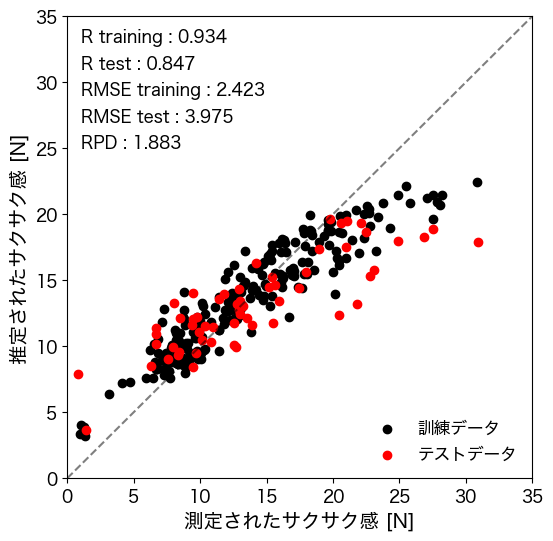

In [8]:
F = 14

fig = plt.figure(figsize=(6,6))
plt.scatter(y_train,y_pred_train_RF,c='k',label='訓練データ')
plt.scatter(y_test,y_pred_RF,c='r',label='テストデータ')
# plt.xlim(3,26)
# plt.ylim(3,26)
# plt.xlim(0,11)
# plt.ylim(0,11)
plt.xlim(0,35)
plt.ylim(0,35)

plt.plot([0,35],[0,35],c='k',linestyle='dashed',alpha=0.5)
plt.xlabel('測定されたサクサク感 [N]',fontsize=F)
plt.ylabel('推定されたサクサク感 [N]',fontsize=F)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=F-2,loc='lower right',frameon=False)

MODEL = 'Random Forest'
plt.text(1.0,33,f"R training : {temp.T[MODEL][0]:.3f}",fontsize=12)
plt.text(1.0,31,f"R test : {temp.T[MODEL][1]:.3f}",fontsize=12)
plt.text(1.0,29,f"RMSE training : {temp.T[MODEL][2]:.3f}",fontsize=12)
plt.text(1.0,27,f"RMSE test : {temp.T[MODEL][3]:.3f}",fontsize=12)
plt.text(1.0,25,f"RPD : {temp.T[MODEL][4]:.3f}",fontsize=12)

# MODEL = 'Random Forest'
# plt.text(0.8,10,f"R training : {temp.T[MODEL][0]:.3f}",fontsize=12)
# plt.text(0.8,9.5,f"R test : {temp.T[MODEL][1]:.3f}",fontsize=12)
# plt.text(0.8,9,f"RMSE training : {temp.T[MODEL][2]:.3f}",fontsize=12)
# plt.text(0.8,8.5,f"RMSE test : {temp.T[MODEL][3]:.3f}",fontsize=12)
# plt.text(0.8,8,f"RPD : {temp.T[MODEL][4]:.3f}",fontsize=12)

# plt.text(4.0,23,f"R training : {temp.T[MODEL][0]:.3f}",fontsize=12)
# plt.text(4.0,22,f"R test : {temp.T[MODEL][1]:.3f}",fontsize=12)
# plt.text(4.0,21,f"RMSE training : {temp.T[MODEL][2]:.3f}",fontsize=12)
# plt.text(4.0,20,f"RMSE test : {temp.T[MODEL][3]:.3f}",fontsize=12)
# plt.text(4.0,19,f"RPD : {temp.T[MODEL][4]:.3f}",fontsize=12)

fig.savefig(f'./../output/図_yyplot_best_{i_col}.png',dpi=400)
plt.show()